In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

In [64]:
import os
os.chdir(r'C:\Users\jacob\OneDrive - University of Louisville\Projects\Dissertation\PhaseI\data_analysis\TRANSONIC\TRANSONIC')
from src.models.LFR_DZ_CSTR import LFR_DZ_CSTR
from src.modules.system_class import System

In [65]:
quants = pd.read_csv("results/run1/results/eval_outputs.csv", index_col=0, 
                     header=0)
DOE = pd.read_csv("data/CASE_PARAMETERS_MODEL.csv", index_col=0, header=0)

quants_and_DOE = DOE.merge(quants, on='CASE_NUM')

FileNotFoundError: [Errno 2] No such file or directory: 'results/run1/results/eval_outputs.csv'

# Boxplot for Relative Absolute Error of Model Arteries

In [66]:
fig = px.box(quants, x="RAE_C", points='all', width=900, height=400,
             labels={"RAE_C": "Relative Absolute Error"}, 
             notched=True)

fig.update_layout(
    paper_bgcolor='white',  # Clean white background
    plot_bgcolor='white',  # White plot background to avoid distractions
    title_font=dict(size=16, color='black', family='Arial'),  # Professional font settings
    xaxis_title_text='Relative Absolute Error',  # Clear and concise axis title
    xaxis=dict(
        title_standoff=10,
        tickfont=dict(family='Arial', size=18),
        title_font=dict(family='Arial', size=22)
    ),
)

pio.write_image(fig, 'results/run1/results/RAE_boxplot.png', 
                format='png', width=1080, height=720)
fig.show()


FileNotFoundError: [Errno 2] No such file or directory: 'results\\run1\\results\\RAE_boxplot.png'

# Visual Comparison of Mathematical Model vs. CFD Data

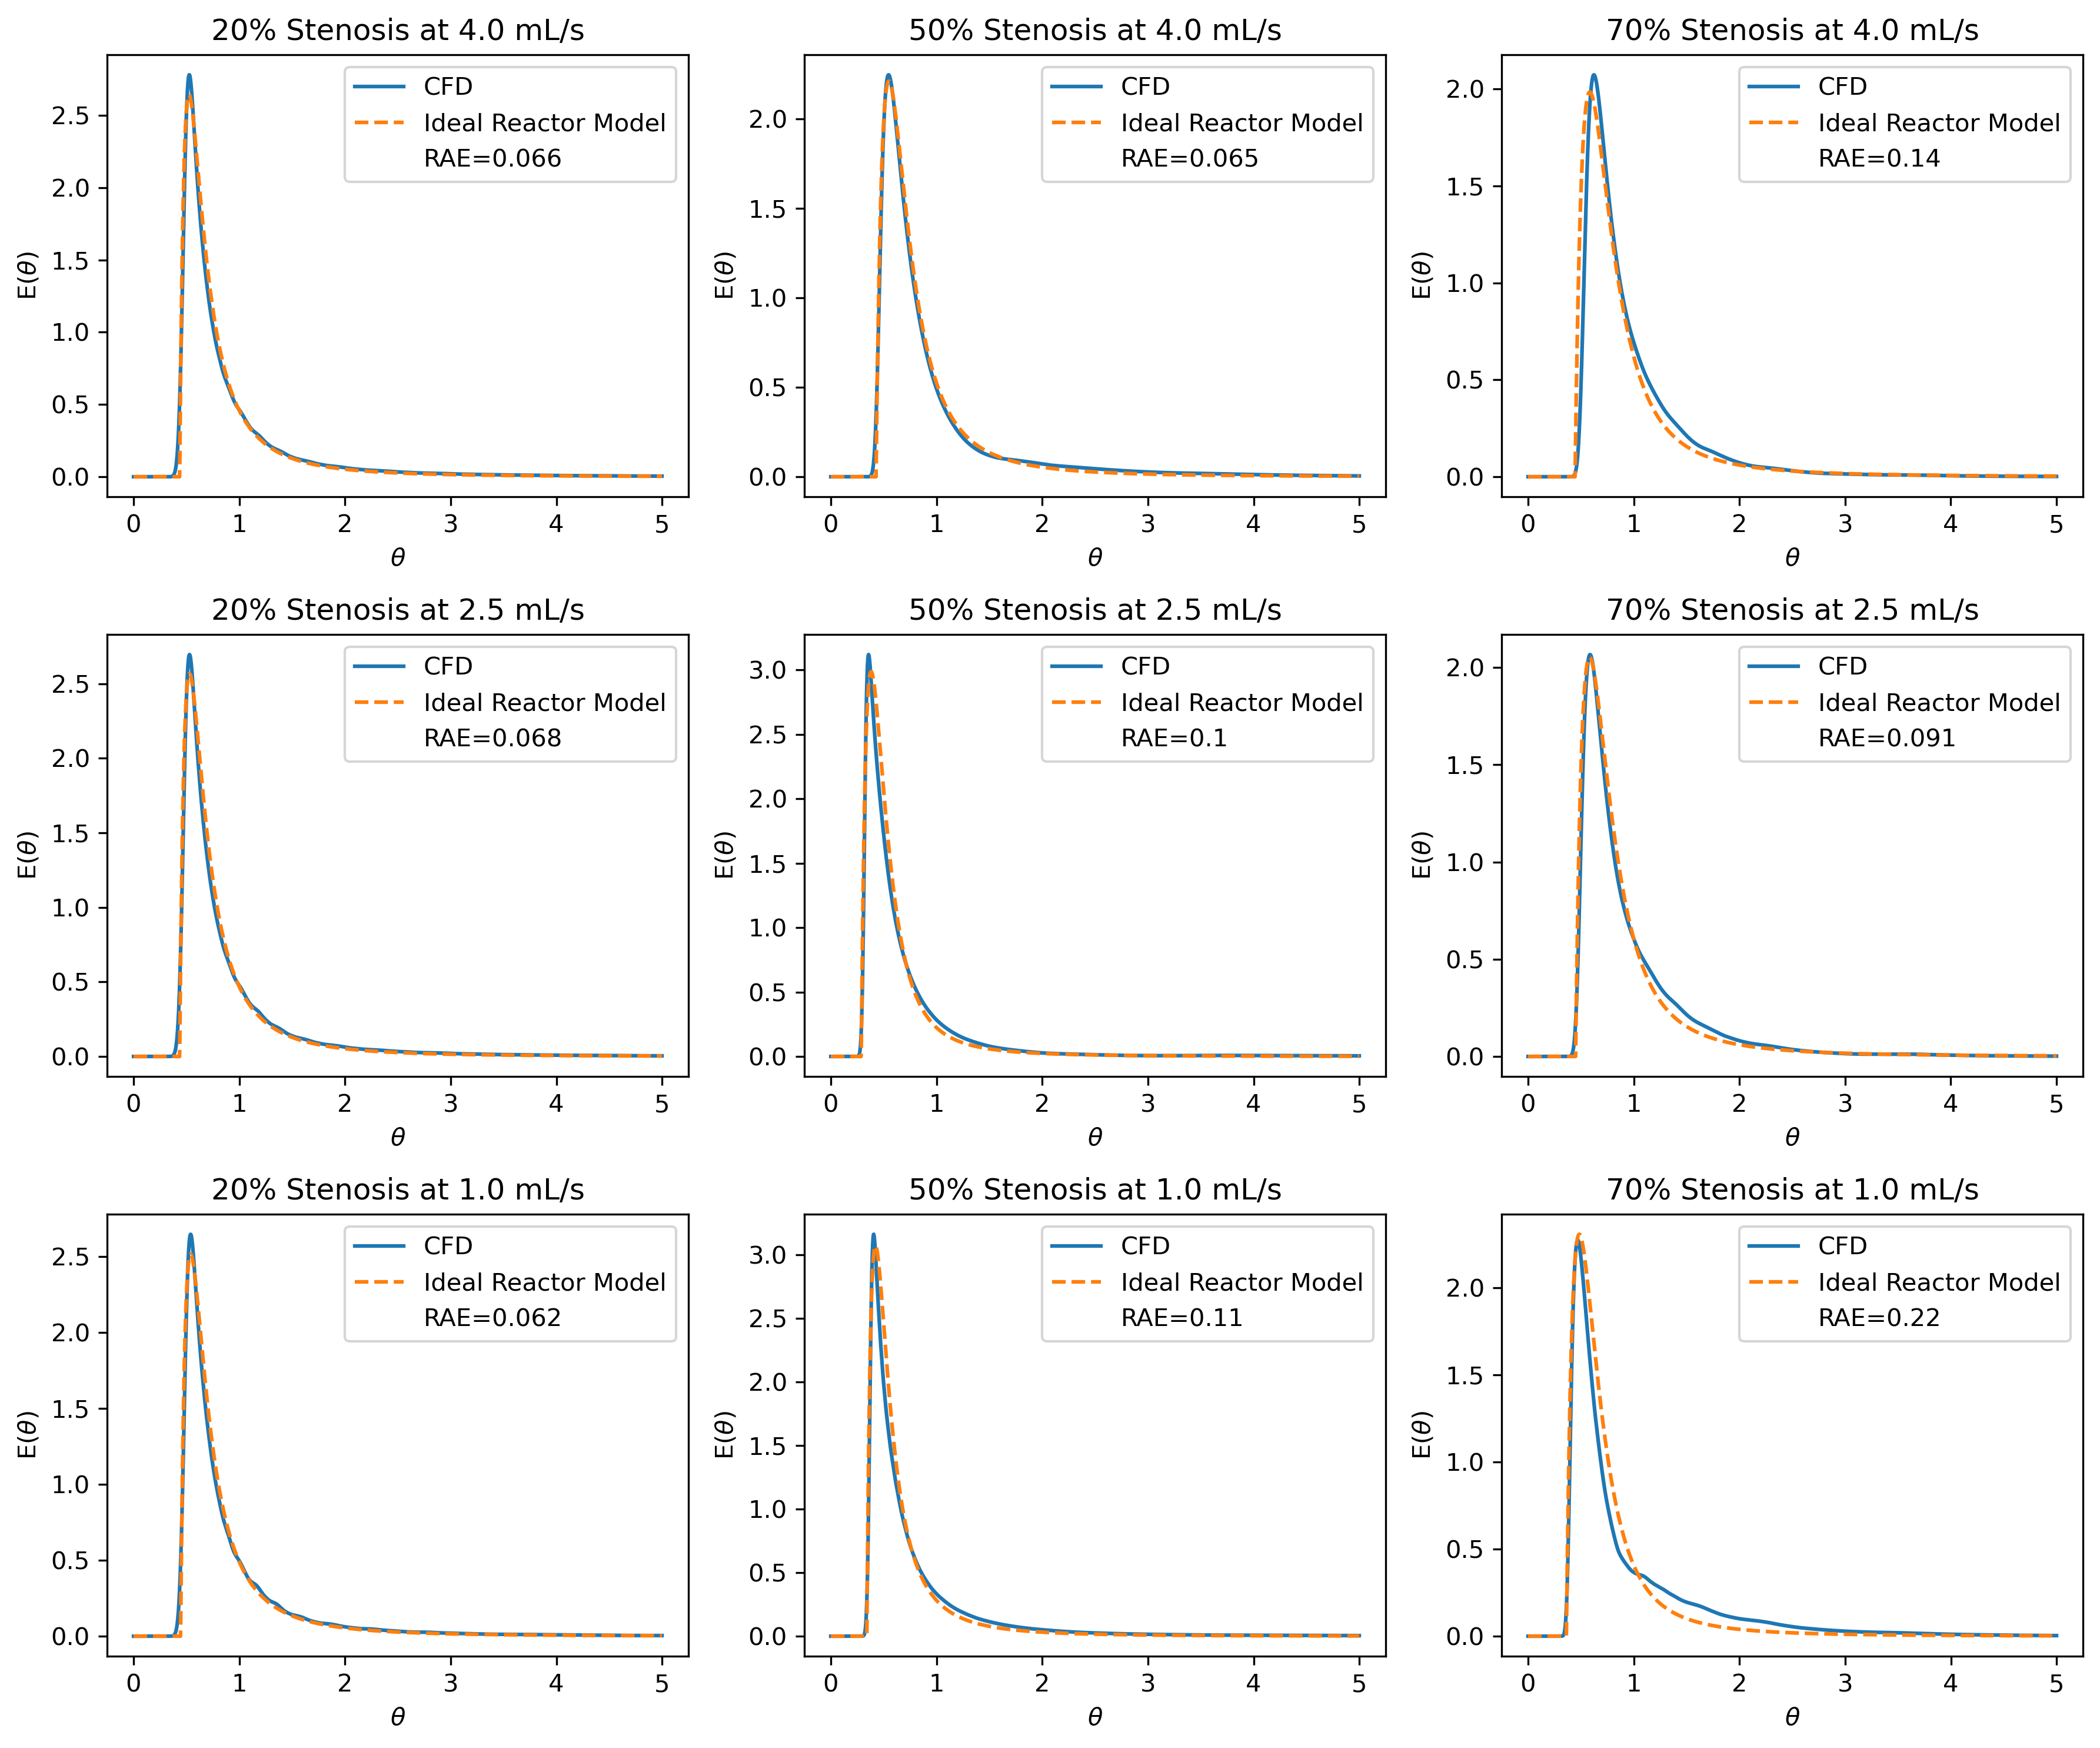

In [131]:
import math
import matplotlib.patches as mpatches
arteries_of_interest = quants_and_DOE[
    (quants_and_DOE['FLOW_RATE'].isin([1, 2.5, 4]))
    & (quants_and_DOE['RAMP_ANGLE'] == 45)
]

wd = r'C:\Users\jacob\OneDrive - University of Louisville\Projects\Dissertation\PhaseI\data_analysis\TRANSONIC\TRANSONIC\results\LFR_DZ_CSTR'
wd = os.path.normpath(wd)

fig, axs = plt.subplots(3, 3, figsize=(12, 10), dpi=300)
i = 0

for ID, features in arteries_of_interest.iterrows():
    artery = System(ID, wd)
    artery.get_system_characteristics(quants_and_DOE)


    # Instantiate mathematical model based on config spec
    model_instance = LFR_DZ_CSTR(
        artery.X.TIMESTEP_SIZE, 
        artery.X.tau, 
        bounds=[[0.01, 0.99], [0.01, 0.99]],
        initial_guess=[0.5, 0.5, 0.5]
    )

    model_instance.params = [features['alpha'], features['beta']]

    artery.predicted_curves(
        artery.C.time, 
        model_instance.predict(artery.C.time)
    )

    column, row = divmod(i, 3)
    ax = axs[row, column]

    CFD_line, = ax.plot(
        artery.Etheta.time, 
        artery.Etheta.Et, 
        label=f'CFD'
    )

    model_line, = ax.plot(
        artery.Etheta_pred.time, 
        artery.Etheta_pred.Et, 
        label=f'Ideal Reactor Model',
        linestyle='--'
    )

    rae_handle = mpatches.Patch(color='None', label=f"RAE={artery.X.RAE_Etheta:.2g}")

    
    ax.set_ylabel(r'E($\theta$)')
    ax.set_xlabel(r'$\theta$')
    ax.legend(handles=[CFD_line, model_line, rae_handle],
        labels=['CFD', 'Ideal Reactor Model', 
                f"RAE={artery.X.RAE_Etheta:.2g}"]
    )

    ax.set_title(f"{artery.X.PERC_DS}% Stenosis at {artery.X.FLOW_RATE} mL/s")
    i += 1

plt.tight_layout()
plt.savefig("results/LFR_DZ_CSTR/results/visual_comparison_of_model_and_CFD.png")
plt.show()
